In [49]:
# Optimize tensorflow for M1 max
from utils import optimize_tf_for_apple_silicon

def save_current_time(time):
    file_path="time_log.txt"
    with open(file_path, "a") as file:
        file.write(time + "\n")

optimize_tf_for_apple_silicon()

Configuration failed. Runtime was already initialized: Intra op parallelism cannot be modified after initialization.
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU with 55GB of memory


Loading and preprocessing data...
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)

Creating and compiling model...

Training model...
Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.1354 - loss: 2.2883 - val_accuracy: 0.1994 - val_loss: 2.1839
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.2272 - loss: 2.1290 - val_accuracy: 0.2763 - val_loss: 1.9721
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.2873 - loss: 1.9677 - val_accuracy: 0.3130 - val_loss: 1.8960
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3183 - loss: 1.8860 - val_accuracy: 0.3521 - val_loss: 1.8077
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.3556 - loss: 1.7959 - val_accuracy: 0.3676 - val_loss: 1.7499

EVALUATION RESULTS
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 

Clean Test Accuracy: 0.3758

Generating adversarial examples...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Adversarial Test Accuracy (PGD): 0.1235
Accuracy Drop: 

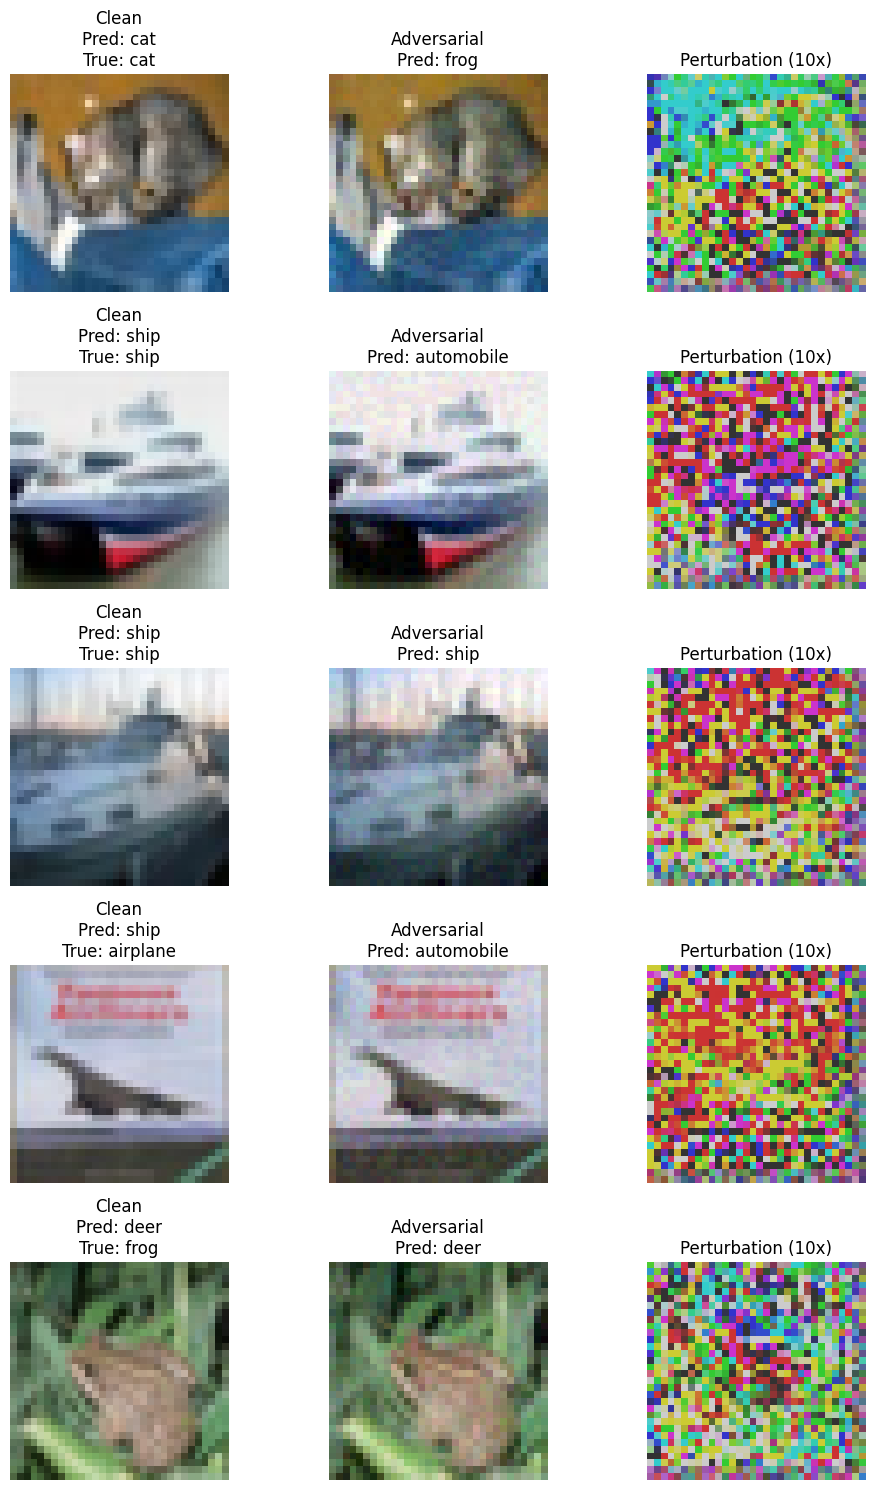

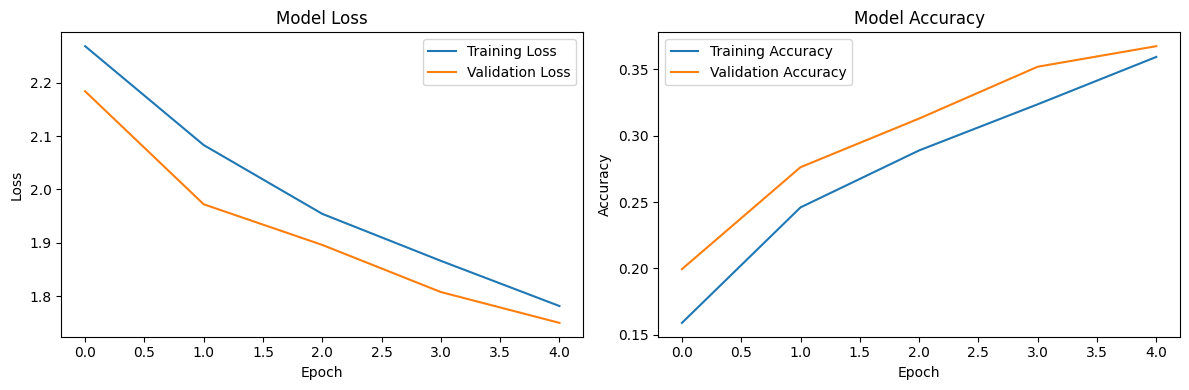


ROBUSTNESS ANALYSIS AT DIFFERENT EPSILON VALUES
Epsilon: 0.000, Accuracy: 0.3758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Epsilon: 0.010, Accuracy: 0.2900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epsilon: 0.020, Accuracy: 0.1940
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Epsilon: 0.030, Accuracy: 0.1320
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epsilon: 0.050, Accuracy: 0.0520
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epsilon: 0.100, Accuracy: 0.0020


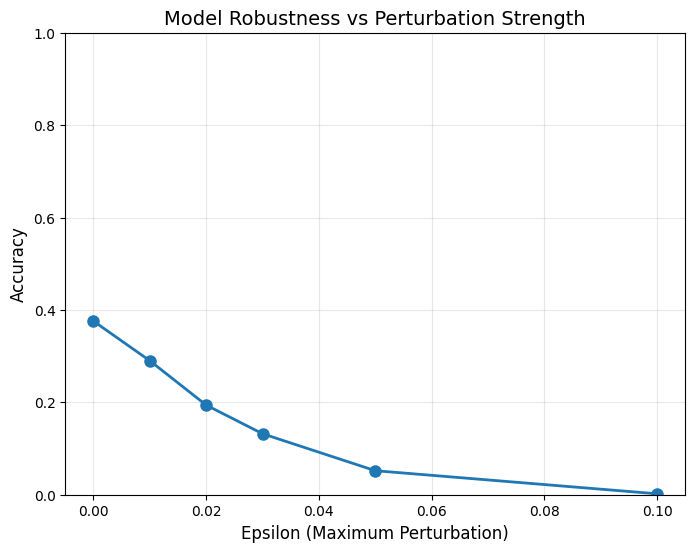



Time: 15.03 seconds


In [ ]:
# CNN performance
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PGDAttack:
    """Projected Gradient Descent attack implementation"""
    
    def __init__(self, model, epsilon, alpha, num_steps):
        """
        Initialize PGD attack
        
        Args:
            model: Target model to attack
            epsilon: Maximum perturbation bound (L-infinity norm)
            alpha: Step size for each iteration
            num_steps: Number of PGD iterations
        """
        self.model = model
        self.epsilon = epsilon
        self.alpha = alpha
        self.num_steps = num_steps
        
    def generate(self, x, y):
        """
        Generate adversarial examples using PGD
        
        Args:
            x: Input images
            y: True labels
            
        Returns:
            Adversarial examples
        """
        # Initialize adversarial examples with random perturbation
        delta = tf.random.uniform(tf.shape(x), -self.epsilon, self.epsilon)
        x_adv = x + delta
        x_adv = tf.clip_by_value(x_adv, 0, 1)
        
        for _ in range(self.num_steps):
            with tf.GradientTape() as tape:
                tape.watch(x_adv)
                predictions = self.model(x_adv)
                loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)
            
            # Calculate gradients
            gradients = tape.gradient(loss, x_adv)
            
            # Update adversarial examples
            x_adv = x_adv + self.alpha * tf.sign(gradients)
            
            # Project back to epsilon ball
            delta = tf.clip_by_value(x_adv - x, -self.epsilon, self.epsilon)
            x_adv = x + delta
            
            # Ensure pixel values are in valid range [0, 1]
            x_adv = tf.clip_by_value(x_adv, 0, 1)
            
        return x_adv

def create_cnn_model(input_shape, num_classes):
    """Create a simple CNN model"""
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def load_and_preprocess_data():
    """Load and preprocess CIFAR-10 dataset"""
    # Load CIFAR-10 dataset
    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    
    # Use only a subset for faster training (optional)
    train_size = 50000 
    test_size = 10000 
    x_train = x_train[:train_size]
    y_train = y_train[:train_size]
    x_test = x_test[:test_size]
    y_test = y_test[:test_size]
    
    # Normalize pixel values to [0, 1]
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    # Flatten labels
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    return (x_train, y_train), (x_test, y_test)

def evaluate_model(model, x, y, batch_size=5000):
    """Evaluate model accuracy"""
    predictions = model.predict(x, batch_size=batch_size)
    predicted_classes = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_classes == y)
    return accuracy

def visualize_adversarial_examples(x_clean, x_adv, predictions_clean, predictions_adv, 
                                  true_labels, class_names, num_examples=5):
    """Visualize clean and adversarial examples side by side"""
    fig, axes = plt.subplots(num_examples, 3, figsize=(10, 3*num_examples))
    
    for i in range(num_examples):
        # Clean image
        axes[i, 0].imshow(x_clean[i])
        axes[i, 0].set_title(f'Clean\nPred: {class_names[predictions_clean[i]]}\nTrue: {class_names[true_labels[i]]}')
        axes[i, 0].axis('off')
        
        # Adversarial image
        axes[i, 1].imshow(x_adv[i])
        axes[i, 1].set_title(f'Adversarial\nPred: {class_names[predictions_adv[i]]}')
        axes[i, 1].axis('off')
        
        # Perturbation (amplified for visibility)
        perturbation = x_adv[i] - x_clean[i]
        axes[i, 2].imshow(perturbation * 10 + 0.5)
        axes[i, 2].set_title('Perturbation (10x)')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def main():
    """Main function to train model and evaluate against adversarial examples"""
    
    print("Loading and preprocessing data...")
    (x_train, y_train), (x_test, y_test) = load_and_preprocess_data()
    
    # Define model parameters
    input_shape = x_train.shape[1:]
    num_classes = 10
    
    # CIFAR-10 class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    print(f"Training data shape: {x_train.shape}")
    print(f"Test data shape: {x_test.shape}")
    
    # Create and compile model
    print("\nCreating and compiling model...")
    model = create_cnn_model(input_shape, num_classes)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Train model
    print("\nTraining model...")
    history = model.fit(x_train, y_train,
                       batch_size=5000,
                       epochs=5,
                       validation_split=0.2,
                       )
    
    # Evaluate on clean test data
    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    
    clean_accuracy = evaluate_model(model, x_test, y_test)
    print(f"\nClean Test Accuracy: {clean_accuracy:.4f}")
    
    # Generate adversarial examples using PGD
    print("\nGenerating adversarial examples...")
    
    # PGD parameters
    epsilon = 0.03  # Maximum perturbation (8/255 for standard robustness evaluation)
    alpha = 0.01    # Step size
    num_steps = 20  # Number of PGD iterations
    
    # Create PGD attack
    pgd_attack = PGDAttack(model, epsilon, alpha, num_steps)
    
    # Generate adversarial examples in batches
    batch_size = 5000
    x_test_adv = []
    
    for i in range(0, len(x_test), batch_size):
        batch_x = x_test[i:i+batch_size]
        batch_y = y_test[i:i+batch_size]
        
        # Convert to tensor for PGD attack
        batch_x_tensor = tf.convert_to_tensor(batch_x)
        batch_y_tensor = tf.convert_to_tensor(batch_y)
        
        # Generate adversarial batch
        batch_adv = pgd_attack.generate(batch_x_tensor, batch_y_tensor)
        x_test_adv.append(batch_adv.numpy())
    
    x_test_adv = np.concatenate(x_test_adv, axis=0)
    
    # Evaluate on adversarial test data
    adv_accuracy = evaluate_model(model, x_test_adv, y_test)
    print(f"Adversarial Test Accuracy (PGD): {adv_accuracy:.4f}")
    print(f"Accuracy Drop: {clean_accuracy - adv_accuracy:.4f}")
    
    # Analyze attack success rate
    clean_predictions = np.argmax(model.predict(x_test), axis=1)
    adv_predictions = np.argmax(model.predict(x_test_adv), axis=1)
    
    # Success rate: percentage of examples where attack changed the prediction
    attack_success_rate = np.mean(clean_predictions != adv_predictions)
    print(f"\nAttack Success Rate: {attack_success_rate:.4f}")
    
    # Calculate average perturbation magnitude
    avg_perturbation = np.mean(np.abs(x_test_adv - x_test))
    max_perturbation = np.max(np.abs(x_test_adv - x_test))
    print(f"Average Perturbation: {avg_perturbation:.4f}")
    print(f"Maximum Perturbation: {max_perturbation:.4f}")
    
    # Visualize some examples
    print("\nVisualizing adversarial examples...")
    visualize_adversarial_examples(
        x_test[:5], 
        x_test_adv[:5], 
        clean_predictions[:5], 
        adv_predictions[:5], 
        y_test[:5], 
        class_names
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: robustness at different epsilon values
    print("\n" + "="*50)
    print("ROBUSTNESS ANALYSIS AT DIFFERENT EPSILON VALUES")
    print("="*50)
    
    epsilons = [0.0, 0.01, 0.02, 0.03, 0.05, 0.1]
    accuracies = []
    
    for eps in epsilons:
        if eps == 0:
            accuracies.append(clean_accuracy)
        else:
            # Create new attack with different epsilon
            pgd_attack_eps = PGDAttack(model, eps, alpha=eps/3, num_steps=20)
            
            # Generate adversarial examples for a subset
            subset_size = 500
            x_subset = x_test[:subset_size]
            y_subset = y_test[:subset_size]
            
            x_subset_tensor = tf.convert_to_tensor(x_subset)
            y_subset_tensor = tf.convert_to_tensor(y_subset)
            
            x_adv_eps = pgd_attack_eps.generate(x_subset_tensor, y_subset_tensor).numpy()
            acc = evaluate_model(model, x_adv_eps, y_subset)
            accuracies.append(acc)
            
        print(f"Epsilon: {eps:.3f}, Accuracy: {accuracies[-1]:.4f}")
    
    # Plot robustness curve
    plt.figure(figsize=(8, 6))
    plt.plot(epsilons, accuracies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Epsilon (Maximum Perturbation)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Model Robustness vs Perturbation Strength', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.show()

start_time = time.time()
main()
end_time = time.time()
print(f"\n\nTime: {end_time - start_time:.2f} seconds")
save_current_time(f"{end_time - start_time:.2f}")